# Machine learning with TensorFlow: CNN

Date: November 4, 2018

Neural network: two convolution layers and three hidden layers

Classification of acoustic events:
- Piano music
- Framenco guitar music
- Classical guitar music
- Blues hars music
- Tin whistle music

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

DATA_FOLDER = '/content/gdrive/My Drive/acoustic_event_detection/data/'
FILTERS=40
TRAINING_FILES = 60
FILES = 90

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import random
import os

## Preparing data set for training CNN

In [0]:
import glob
piano_files = glob.glob(DATA_FOLDER+'*piano*mel_spectrogram*.csv')
classical_guitar_files = glob.glob(DATA_FOLDER+'*classical_guitar*mel_spectrogram*.csv')
framenco_guitar_files = glob.glob(DATA_FOLDER+'*framenco_guitar*mel_spectrogram*.csv')
blues_harp_files = glob.glob(DATA_FOLDER+'*blues_harp*mel_spectrogram*.csv')
tin_whistle_files = glob.glob(DATA_FOLDER+'*tin_whistle*mel_spectrogram*.csv')

random.shuffle(piano_files)
random.shuffle(classical_guitar_files)
random.shuffle(framenco_guitar_files)
random.shuffle(blues_harp_files)
random.shuffle(tin_whistle_files)

In [0]:
TRAINING_SET_PIANO = piano_files[:TRAINING_FILES]
TRAINING_SET_CLASSICAL_GUITAR = classical_guitar_files[:TRAINING_FILES]
TRAINING_SET_FRAMENCO_GUITAR = framenco_guitar_files[:TRAINING_FILES]
TRAINING_SET_BLUES_HARP = blues_harp_files[:TRAINING_FILES]
TRAINING_SET_TIN_WHISTLE = tin_whistle_files[:TRAINING_FILES]

TEST_SET_PIANO = piano_files[TRAINING_FILES:FILES]
TEST_SET_CLASSICAL_GUITAR = classical_guitar_files[TRAINING_FILES:FILES]
TEST_SET_FRAMENCO_GUITAR = framenco_guitar_files[TRAINING_FILES:FILES]
TEST_SET_BLUES_HARP = blues_harp_files[TRAINING_FILES:FILES]
TEST_SET_TIN_WHISTLE = tin_whistle_files[TRAINING_FILES:FILES]

TRAINING_SET = [(TRAINING_SET_PIANO, 0),
                (TRAINING_SET_CLASSICAL_GUITAR, 1),
                (TRAINING_SET_FRAMENCO_GUITAR, 2),
                (TRAINING_SET_BLUES_HARP, 3),
                (TRAINING_SET_TIN_WHISTLE, 4)]

TEST_SET = [(TEST_SET_PIANO, 0),
            (TEST_SET_CLASSICAL_GUITAR, 1),
            (TEST_SET_FRAMENCO_GUITAR, 2),
            (TEST_SET_BLUES_HARP, 3),
            (TEST_SET_TIN_WHISTLE, 4)]

In [0]:
training_set = []
test_set = []

a1, a2 = 0,  FILTERS*100
b1, b2 = FILTERS*50, FILTERS*150
c1, c2 = FILTERS*100, FILTERS*200

def label(l):
    ll = [0,0,0,0,0]
    ll[l] = 1
    return ll

for files, l in TRAINING_SET:
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.int16)
        #df = df[df['n']<FILTERS]
        # Mean normalization
        df['magnitude'] = df['magnitude'] -  df['magnitude'].mean()
        training_set.append((df[a1:a2], label(l)))
        training_set.append((df[b1:b2], label(l)))
        training_set.append((df[c1:c2], label(l)))
        
for files, l in TEST_SET:
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.int16)
        #df = df[df['n']<FILTERS]
        # Mean normalization
        df['magnitude'] = df['magnitude'] - df['magnitude'].mean()
        test_set.append((df[a1:a2], label(l)))
        test_set.append((df[b1:b2], label(l)))
        test_set.append((df[c1:c2], label(l)))
                        
random.shuffle(training_set)
random.shuffle(test_set)

In [0]:
train_x, train_t = [], []
test_x, test_t = [], []
for df, label in training_set:
    train_x.append(df['magnitude'])
    train_t.append(label)
for df, label in test_set:
    test_x.append(df['magnitude'])
    test_t.append(label)

## CNN on TensorFlow

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20181031)
tf.set_random_seed(20181031)

### Convolution layer

In [0]:
num_samples = FILTERS * 100
num_classes = 5

num_filters1 = 64
num_filters2 = 128
num_filters3 = 128

num_layers = 1

x = tf.placeholder(tf.float32, [None, FILTERS*100])

x_image = tf.reshape(x, [-1,100,FILTERS,1])

W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, num_filters1], stddev=0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME')
b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)
h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

W_conv2 = tf.Variable(tf.truncated_normal([5, 5, num_filters1, num_filters2], stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1,1,1,1], padding='SAME')
b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)
h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

W_conv3 = tf.Variable(tf.truncated_normal([5, 5, num_filters2, num_filters3], stddev=0.1))
h_conv3 = tf.nn.conv2d(h_pool2, W_conv3, strides=[1,1,1,1], padding='SAME')
b_conv3 = tf.Variable(tf.constant(0.1, shape=[num_filters3]))
h_conv3_cutoff = tf.nn.relu(h_conv3 + b_conv3)
h_pool3 = tf.nn.max_pool(h_conv3_cutoff, ksize=[1,1,1,1], strides=[1,1,1,1], padding='SAME')

h_pool_flat3 = tf.reshape(h_pool3, [-1, int(FILTERS/4)*25*num_filters3])
#h_pool_flat2 = tf.reshape(h_pool2, [-1, int(FILTERS/4)*25*num_filters2])

### Fully connected layer

In [0]:
num_units1 = int(FILTERS/4)*25*num_filters3
#num_units1 = int(FILTERS/4)*25*num_filters2
#num_units2 = 4096
num_units2 = 2048

num_classes = 5

w1 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b1 = tf.Variable(tf.zeros([num_units2]))
y1 = tf.matmul(h_pool_flat3, w1) + b1
#y1 = tf.matmul(h_pool_flat2, w1) + b1
hidden1 = tf.nn.relu(y1)

w2 = tf.Variable(tf.truncated_normal([num_units2, num_units2]))
b2 = tf.Variable(tf.zeros([num_units2]))
y2 = tf.matmul(hidden1, w2) + b2
hidden2 = tf.nn.relu(y2)

w3 = tf.Variable(tf.truncated_normal([num_units2, num_units2]))
b3 = tf.Variable(tf.zeros([num_units2]))
y3 = tf.matmul(hidden2, w3) + b3
hidden3 = tf.nn.tanh(y3)

keep_prob = tf.placeholder(tf.float32)
hidden3_drop = tf.nn.dropout(hidden3, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, num_classes]))
b0 = tf.Variable(tf.zeros([num_classes]))
p = tf.nn.softmax(tf.matmul(hidden3_drop, w0) + b0)

In [0]:
t = tf.placeholder(tf.float32, [None, num_classes])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.00005).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [17]:
i = 0
for _ in range(800):
    i += 1
    sess.run(train_step, feed_dict={x:train_x, t:train_t, keep_prob:0.5})
    if i % 20 == 0:
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={x:test_x, t:test_t, keep_prob:1.0})
        print('Step: {}, Loss: {}, Accuracy: {}'.format(i, loss_val, acc_val))

Step: 20, Loss: 645.5425415039062, Accuracy: 0.8222222328186035
Step: 40, Loss: 581.1756591796875, Accuracy: 0.846666693687439
Step: 60, Loss: 528.7759399414062, Accuracy: 0.8488888740539551
Step: 80, Loss: 486.4460144042969, Accuracy: 0.846666693687439
Step: 100, Loss: 451.8622131347656, Accuracy: 0.851111114025116
Step: 120, Loss: 426.0226745605469, Accuracy: 0.846666693687439
Step: 140, Loss: 408.1875, Accuracy: 0.846666693687439
Step: 160, Loss: 381.46759033203125, Accuracy: 0.8488888740539551
Step: 180, Loss: 362.84002685546875, Accuracy: 0.855555534362793
Step: 200, Loss: 341.1737060546875, Accuracy: 0.8600000143051147
Step: 220, Loss: 326.3684997558594, Accuracy: 0.8622221946716309
Step: 240, Loss: 313.1927185058594, Accuracy: 0.8600000143051147
Step: 260, Loss: 302.1601257324219, Accuracy: 0.8644444346427917
Step: 280, Loss: 298.5766906738281, Accuracy: 0.855555534362793
Step: 300, Loss: 291.531005859375, Accuracy: 0.855555534362793
Step: 320, Loss: 278.53729248046875, Accuracy

### Confirmation with test data set

In [18]:
p_test = sess.run(p, feed_dict={x:test_x, keep_prob:1.0})
(p_test*100).astype(int)[:16]

array([[33, 60,  4,  0,  0],
       [ 1,  0,  0,  3, 94],
       [23, 39, 32,  3,  1],
       [ 1,  0,  2, 95,  0],
       [42, 39, 12,  2,  2],
       [ 8,  0,  0,  5, 84],
       [31, 58,  7,  0,  0],
       [ 0,  0,  0,  4, 94],
       [34, 61,  3,  1,  0],
       [ 0,  1, 93,  4,  0],
       [ 1,  0, 16, 76,  4],
       [ 1,  6, 82,  8,  0],
       [37, 55,  5,  1,  0],
       [79,  3,  0,  0, 15],
       [ 6,  3, 30, 54,  4],
       [59, 28,  6,  4,  1]])

In [19]:
test_t[:16]

[[0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0],
 [0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0]]

In [0]:
filter_vals, conv_vals = sess.run([W_conv3, h_pool3], feed_dict={x:train_x})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


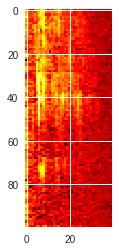

In [21]:
plt.imshow(train_x[20].reshape(100,FILTERS), interpolation='nearest', cmap=plt.cm.hot)

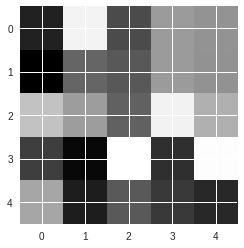

In [22]:
plt.imshow(filter_vals[:,:,0,77], interpolation='nearest', cmap=plt.cm.gray_r)

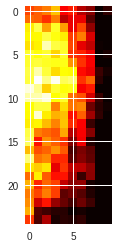

In [23]:
plt.imshow(conv_vals[20,:,:,77], interpolation='nearest', cmap=plt.cm.hot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  del sys.path[0]


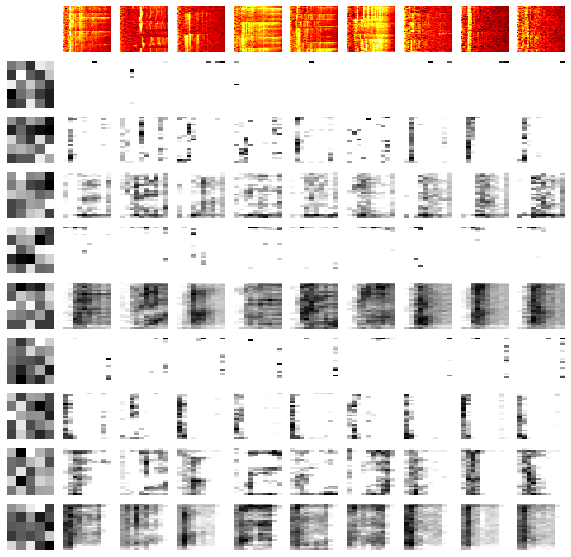

In [24]:
fig = plt.figure(figsize=(10,10))

for j in range(9):
  subplot = fig.add_subplot(10,10,10*(j+1)+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(filter_vals[:,:,0,j],cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
  subplot = fig.add_subplot(10,10,i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(train_x[i].reshape(100,FILTERS),cmap=plt.cm.hot, interpolation='nearest', aspect='auto')
    
for j in range(9):
  for i in range(9):
    subplot = fig.add_subplot(10,10,10*(j+1)+2+i)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,j],cmap=plt.cm.gray_r, interpolation='nearest', aspect='auto')

fig.savefig(DATA_FOLDER+'/filterd_spectrogram.png')